# Pathologies of COT-FM and T-COT-FM compared with CVFM

We saw in the CVFM tutorial notebook the ability of CVFM to disentangle conditional dynamics between arbitrary source and target distributions, although we neglected to look closer at base COT-FM, described in [Kerrigan et al. (2024)](https://arxiv.org/abs/2404.04240) & [Chemseddine et al. (2024)](https://arxiv.org/abs/2403.18705). These works concurrently identified the optimal transport (OT) ground cost function

$$ c((x_i,y_i),(x_j,y_j)) = \lVert x_i - x_j \rVert_p + \eta \lVert y_i - y_j \rVert_p $$

where $\eta > 0$ is a parameter governing the tolerance of transport permissible in $\mathcal{Y}$. Although, detrimentally we will show through this example, that the ability to still sample mismatched $y_0 != y_1$ degrades overall performance. As implemented COT-FM relies exclusively upon this conditional cost to compute the coupling $\pi((x_0,y_0),(x_1,y_1))$.

We noted during the development of CVFM that this cost is both insufficient to produce reliable mappings, and demonstrates a high degree of sensitivity to the selection of $\eta$. CVFM ameliorates this issue through the introduction of the stationary kernel across $y$, dynamically influencing the objective as

$$ \mathcal{L}_{\textrm{CVFM}}(\theta) = \mathbb{E}_{t, q(z, w), p_t(x | z) p_t(y| w)} \left[ \alpha(w) \lVert v_\theta(x, y, t) - u_t(x | z) \rVert^2 \right] $$

The benefits of $\alpha(w)$ will become increasingly apparant in the 2D example below. In this example, we will first focus on a challenging mapping between 8 Gaussians - 8 Gaussians as reported in our paper, and later show an extension to the classical base $\mathcal{N}(0,1)$ distribution.

In [24]:
import numpy as np
import ot as pot
import math
import torch
from torchdyn.core import NeuralODE
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

In [25]:
def eight_normal_sample(n, dim, scale=1, var=1, theta=0):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    
    theta = np.radians(theta)
    rot_mat = torch.tensor([[np.cos(theta), -np.sin(theta)],
                             [np.sin(theta),  np.cos(theta)]],dtype=torch.float32)
    data = torch.matmul(data.float(), rot_mat)
   
    return data, multi.float()

def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()

In [26]:
class MLP(torch.nn.Module):
    def __init__(self, dim, cdim, w=64):
        super().__init__()
        self.dim = dim
        self.cdim = cdim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + cdim + 1, w),
            torch.nn.GELU(),
            torch.nn.Linear(w, w),
            torch.nn.GELU(),
            torch.nn.Linear(w, w),
            torch.nn.GELU(),
            torch.nn.Linear(w, dim),
        )

    def forward(self, x, y, t):
        in_x = torch.cat([x, y, t], dim=-1)
        out = self.net(in_x)
        return out
    
class torchdyn_wrapper(torch.nn.Module):
    def __init__(self, model, y):
        super().__init__()
        self.model = model
        self.y = y
        
    def forward(self, t, x, args=None):  
        return self.model(x, self.y, t.repeat(x.shape[0])[:, None]) 

def plot_trajectories(traj, y):   
    n = 2000
    y = y[:n].astype('int')
    
    cmap = plt.get_cmap('RdBu')
    norm = plt.Normalize(vmin=y.min(), vmax=y.max())
    colors = cmap(norm(y)) 
    
    plt.figure(figsize=(8, 8))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black",zorder=5)
    for i in range(n):
        plt.plot(traj[:, i, 0], traj[:, i, 1], color=colors[i], alpha=0.1,zorder=0)
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="maroon",zorder=10)
    plt.legend([r"$p_0$", r"$x_{t} \vert x_{0}$", r"$p_1$"])
    plt.axis('off')
    plt.xlim([-13,13])
    plt.ylim([-13,13])
    plt.show()

In [27]:
def sample_x0y0_x1y1(batch_size=256):
    x0, y0 = eight_normal_sample(batch_size, 2, scale=10, var=0.2)
    x1, y1 = eight_normal_sample(batch_size, 2, scale=5, var=0.1, theta=45)
    y0 = y0.unsqueeze(-1)
    y1 = y1.unsqueeze(-1)

    return x0, y0, x1, y1

def train(model,
          optimizer,
          n_epoch=10000,
          batch_size=256,
          sigma=0.1,
          sigmay=0.01,
          oty=10,
          sample_fn=sample_x0y0_x1y1,
          flow_type='cvfm'):

    a, b = pot.unif(batch_size), pot.unif(batch_size)
    for k in range(n_epoch):
        optimizer.zero_grad()
        t = torch.randn(batch_size, 1).to(device)
        t = torch.nn.Sigmoid()(t)

        x0, y0, x1, y1 = sample_fn(batch_size)
        
        # Randomly shuffle to account for torchdyn ordered sampling
        ind0 = torch.randperm(x0.size()[0])
        ind1 = torch.randperm(x1.size()[0])
        x0, y0 = x0[ind0].to(device), y0[ind0].to(device)
        x1, y1 = x1[ind1].to(device), y1[ind1].to(device)  
        
        if flow_type == 'cfm':
            # calculate regression loss
            mu_t = t*x1
            sigma_t = 1 - (1 - sigma)*t
            x = mu_t + sigma_t * torch.randn_like(x0).to(device)
            ut = (x1 - (1 - sigma)*x)/(1 - (1 - sigma)*t) 
            vt = model(x, y1, t) 
            
            loss = torch.mean((vt - ut) ** 2) 
            
        else:
            # Resample xy0, xy1 according to transport matrix
            M = torch.cdist(x0, x1) ** 2 + oty*torch.cdist(y0, y1) ** 2
            M = M / M.max()
            pi = pot.emd(a, b, M.detach().cpu().numpy())
            p = pi.flatten()
            p = p / p.sum()
            choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size, replace=False)
            i, j = np.divmod(choices, pi.shape[1])   
            x0 = x0[i]
            x1 = x1[j]
            y0 = y0[i] 
            y1 = y1[j]
    
            # calculate regression loss
            mu_t = x0 * (1 - t) + x1 * t
            muy_t = y0 * (1 - t) + y1 * t
            
            x = mu_t + sigma * torch.randn_like(x0).to(device)
            y = muy_t + sigmay * torch.randn_like(y0).to(device)

            if flow_type == 'cvfm-normal':
                y = y1
            
            ut = x1 - x0
            vt = model(x, y, t)  
    
            # SE kernel in conditioning variable
            if flow_type == 'cvfm':
                yerr = torch.exp(-0.5 * ((y1 - y0) / sigmay) ** 2)
                loss = torch.mean(yerr * (vt - ut) ** 2) 
            else:
                loss = torch.mean((vt - ut) ** 2) 
                       
        loss.backward()
        optimizer.step()

        if (k + 1) % 2000 == 0:
            print(f"{k+1}: loss {loss.item():0.3f}")

            x0, y0, _, _ = sample_fn(2048)
            x0, y0 = x0.to(device), y0.to(device)
            
            node = NeuralODE(
                torchdyn_wrapper(model, y0), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
            ).to(device)
            
            with torch.no_grad():
                traj = node.trajectory(
                    x0,
                    t_span=torch.linspace(0, 1, 100),
                )

                plot_trajectories(traj.detach().cpu().numpy(), y0.detach().cpu().numpy())
                

First, we'll look at setting $\eta = 10$ across both CVFM and COT-FM.

2000: loss 0.108


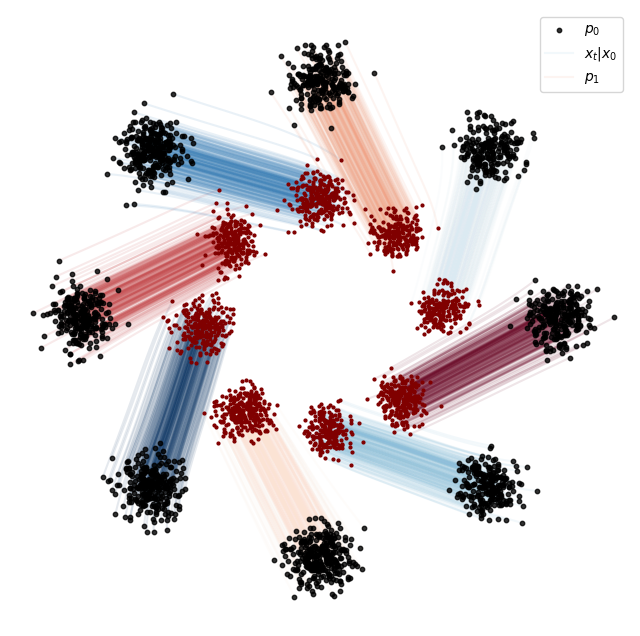

In [28]:
dim = 2
cdim = 1

model = MLP(dim=dim, cdim=cdim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model,
      optimizer,
      n_epoch=2000,
      batch_size=256,
      sigma=0.1,
      sigmay=0.01,
      oty=10,
      sample_fn=sample_x0y0_x1y1,
      flow_type='cvfm')

We can see that with $\eta=10$, CVFM is able to reliably establish the desired mapping between 8 Gaussians to 8 Gaussians (trajectories are colored by the corresponding conditional variable).

2000: loss 0.252


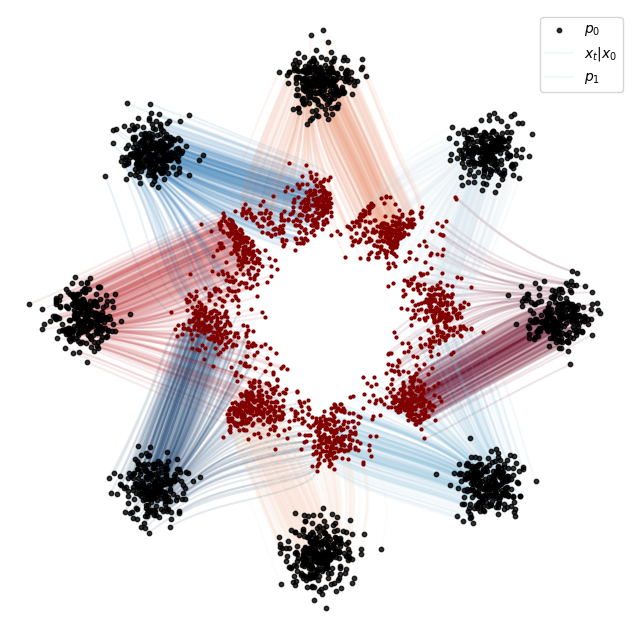

In [29]:
model = MLP(dim=dim, cdim=cdim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model,
      optimizer,
      n_epoch=2000,
      batch_size=256,
      sigma=0.1,
      sigmay=0.01,
      oty=10,
      sample_fn=sample_x0y0_x1y1,
      flow_type='cotfm')

We can clearly see the inability of COT-FM to correctly disentangle the discrete conditional mapping, instead attempting to split mass between conditional distributions so as to purely minimize the specified ground cost function. Clearly, our selection of $\eta=10$ may be insufficiently penalizing transport across $\mathcal{Y}$ in our example. We next severely elevate $\eta=1000$, although as we'll see, even this is insufficient.

2000: loss 1.357


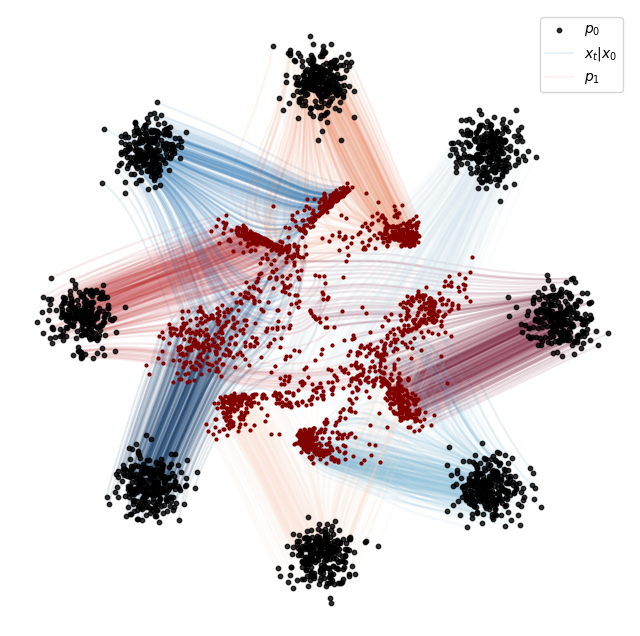

In [30]:
model = MLP(dim=dim, cdim=cdim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model,
      optimizer,
      n_epoch=2000,
      batch_size=256,
      sigma=0.1,
      sigmay=0.01,
      oty=1000,
      sample_fn=sample_x0y0_x1y1,
      flow_type='cotfm')

Now, we'll take a slight shift in demonstrating application to a soucre $\mathcal{N}(0,1)$ distribution.

2000: loss 0.620


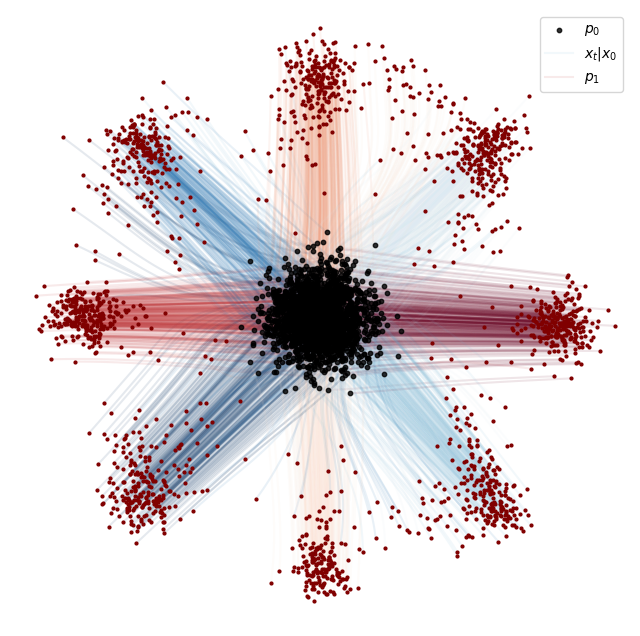

4000: loss 0.209


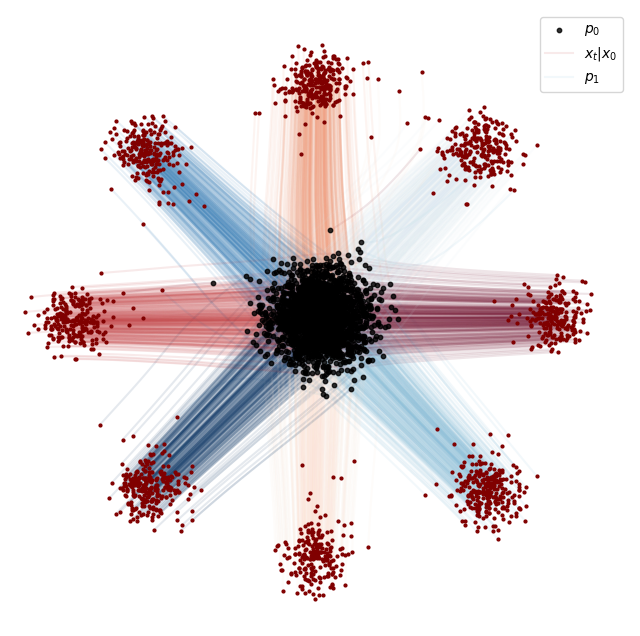

6000: loss 0.284


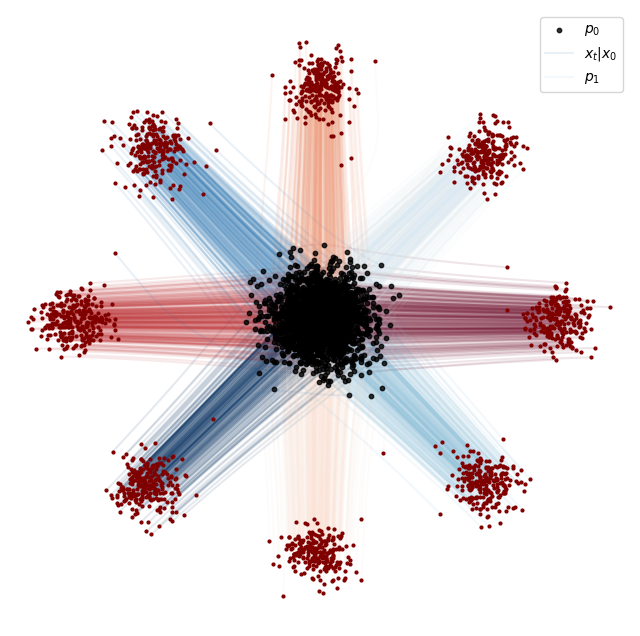

In [31]:
def sample_x0y0_x1y1_normal(batch_size=256):
    x1, y1 = eight_normal_sample(batch_size, 2, scale=10, var=0.2)
    x0 = torch.randn_like(x1)
    y0 = y1

    y0 = y0.unsqueeze(-1)
    y1 = y1.unsqueeze(-1)

    return x0, y0, x1, y1

model = MLP(dim=dim, cdim=cdim, w=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model,
      optimizer,
      n_epoch=6000,
      batch_size=256,
      sigma=0.1,
      sigmay=0.01,
      oty=100,
      sample_fn=sample_x0y0_x1y1_normal,
      flow_type='cvfm-normal')

Although we also note that base OT-FM [Tong et al. (2023)](https://arxiv.org/abs/2302.00482) and FM [Lipman et al. (2023)](https://arxiv.org/abs/2210.02747) are similarly capable of learning this mapping. We'll quickly show an example with base FM below.

2000: loss 1.152


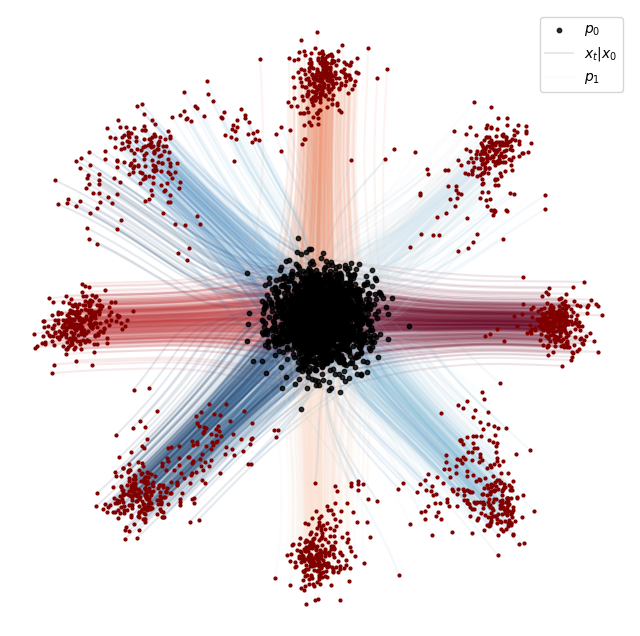

4000: loss 1.132


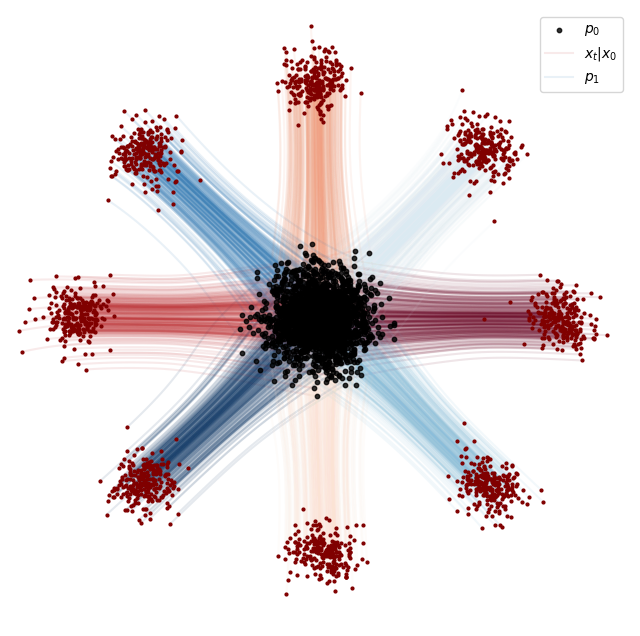

6000: loss 1.088


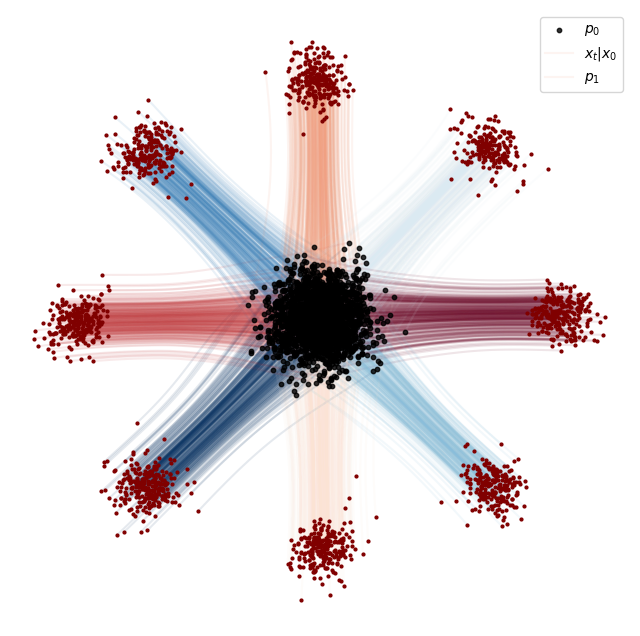

In [32]:
model = MLP(dim=dim, cdim=cdim, w=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model,
      optimizer,
      n_epoch=6000,
      batch_size=256,
      sigma=0.1,
      sample_fn=sample_x0y0_x1y1_normal,
      flow_type='cfm')